In [1]:
#!pip install networkx

In [2]:
import pandas as pd
import numpy as np
import os as os
import aux.acessos as ac
import aux.aed as aed
import pickle
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import random
from statsmodels.tsa.stattools import grangercausalitytests

# Query

In [3]:
query = """

with kpis as (
    select 
        dt_chat,
        count(distinct info_cliente.id_issue) as chats
        , count(distinct case when issues_macro.is_recontato_2d = 1 then info_cliente.id_issue end) / cast(count(distinct info_cliente.id_issue) as double) as tx_recontato
        , avg(issues_macro.nr_tma_resolucao) as nr_tma_resolucao 
        , avg(issues_macro.nr_tpr) as nr_tpr
        , count(distinct case when novas_tags.fila_de_atendimento = 'Pagamento' then info_cliente.id_issue end) / cast(count(distinct info_cliente.id_issue) as double)
        as p_pagamento
        , count(distinct case when novas_tags.fila_de_atendimento = 'Fatura' then info_cliente.id_issue end) / cast(count(distinct info_cliente.id_issue) as double)
        as p_fatura
        , count(distinct case when novas_tags.fila_de_atendimento = 'Fraude' then info_cliente.id_issue end) / cast(count(distinct info_cliente.id_issue) as double)
        as p_fraude
        , count(distinct case when novas_tags.fila_de_atendimento = 'Logistica' then info_cliente.id_issue end) / cast(count(distinct info_cliente.id_issue) as double)
        as p_logistica
        , count(distinct case when novas_tags.fila_de_atendimento = 'Geral' and novas_tags.hierarquia_1 = 'Cartão' then info_cliente.id_issue end) / cast(count(distinct info_cliente.id_issue) as double)
        as p_geral_cartao
        , count(distinct case when novas_tags.fila_de_atendimento = 'Geral' and novas_tags.hierarquia_1 = 'Conta' then info_cliente.id_issue end) / cast(count(distinct info_cliente.id_issue) as double)
        as p_geral_conta
        , count(distinct case when novas_tags.fila_de_atendimento = 'Cadastro' then info_cliente.id_issue end) / cast(count(distinct info_cliente.id_issue) as double)
        as p_cadastro
        , count(distinct case when novas_tags.fila_de_atendimento = 'Geral' and novas_tags.hierarquia_1 = 'Tecnologia' then info_cliente.id_issue end) / cast(count(distinct info_cliente.id_issue) as double)
        as p_geral_tecnologia
        , count(distinct case when is_finalizacao_automacao = 1 then info_cliente.id_issue else null end ) as qtd_encerrado_inatividade
        , avg(issues_macro.nr_csat) as nr_csat
    FROM cx_curated_zone.cx_contact_rate  AS info_cliente
    left join cx_curated_zone.helpshift_issues AS issues_macro ON info_cliente.id_issue = issues_macro.id_issue
    left join "cx_curated_zone"."helpshift_tag_niveis" AS helpshift_tag ON info_cliente."id_issue" = helpshift_tag."id_issue"
    left join processed_zone_api_cxm_tags.tags_hierarquia_gerencial as novas_tags ON trim(lower(n3)) = trim(lower(nm_tag_n3))
    Where dt_chat >= to_date('2021-01-01','yyyy-mm-dd') and dt_chat <= to_date('2023-03-31','yyyy-mm-dd')
     group by 1
     order by 1
)
, retencao as (
    select
dt_chat
, (qtd_resolvido_bot + qtd_encerrado_inatividade - qtd_reabertura) / cast(qtd_issues as double) as tx_retencao_liquida
, (qtd_resolvido_bot) / cast(qtd_issues as double) as p_resolvido_bot
from (
	select  
		cast(substring(cast(dt_criacao_chat as varchar), 1, 10) as date) as dt_chat 
		, count(distinct case when is_abandono_bot !=1 and is_resolvido_bot = 1 then id_issue else null end) as qtd_resolvido_bot
		, count(distinct case when is_abandono_bot = 1 then id_issue else null end ) as qtd_encerrado_inatividade
		, count(distinct case when is_recontato_bot>0 then id_issue else null end) as qtd_reabertura
		, count(distinct id_issue) as qtd_issues
	from cx_curated_zone.helpshift_bots
		group by 1
		order by 1
	)
)
select
k.dt_chat
, chats
, tx_recontato
, nr_tma_resolucao
, nr_tpr
, nr_csat
, qtd_encerrado_inatividade
, tx_retencao_liquida
, cast(p_pagamento * 100 as integer) as p_pagamento
, cast(p_fatura * 100 as integer) as p_fatura
, cast(p_fraude * 100 as integer) as p_fraude
, cast(p_logistica * 100 as integer) as p_logistica
, cast(p_geral_cartao * 100 as integer) as p_geral_cartao
, cast(p_geral_conta * 100 as integer) as p_geral_conta
, cast(p_cadastro * 100 as integer) as p_cadastro
, cast(p_geral_tecnologia * 100 as integer) as p_geral_tecnologia
, p_resolvido_bot
, e.is_holiday
, e.is_event
, case when e.ds_holiday_or_event is null then '0_dia_normal' else e.ds_holiday_or_event end as ds_holiday_or_event
from kpis k
left join retencao r on (r.dt_chat = k.dt_chat)
left join customer_curated_zone.ca_dict_events e on (k.dt_chat = e.dt_date)
order by 1

"""

df = ac.df_athena('flavia-costa', query)


### Tratamento de Missings

In [4]:
for i in df.columns:
    print(i)
    print(df[i].isnull().sum())
    print("-----")

dt_chat
0
-----
chats
0
-----
tx_recontato
0
-----
nr_tma_resolucao
0
-----
nr_tpr
0
-----
nr_csat
0
-----
qtd_encerrado_inatividade
0
-----
tx_retencao_liquida
365
-----
p_pagamento
0
-----
p_fatura
0
-----
p_fraude
0
-----
p_logistica
0
-----
p_geral_cartao
0
-----
p_geral_conta
0
-----
p_cadastro
0
-----
p_geral_tecnologia
0
-----
p_resolvido_bot
365
-----
is_holiday
0
-----
is_event
0
-----
ds_holiday_or_event
0
-----


## Análise de algumas séries

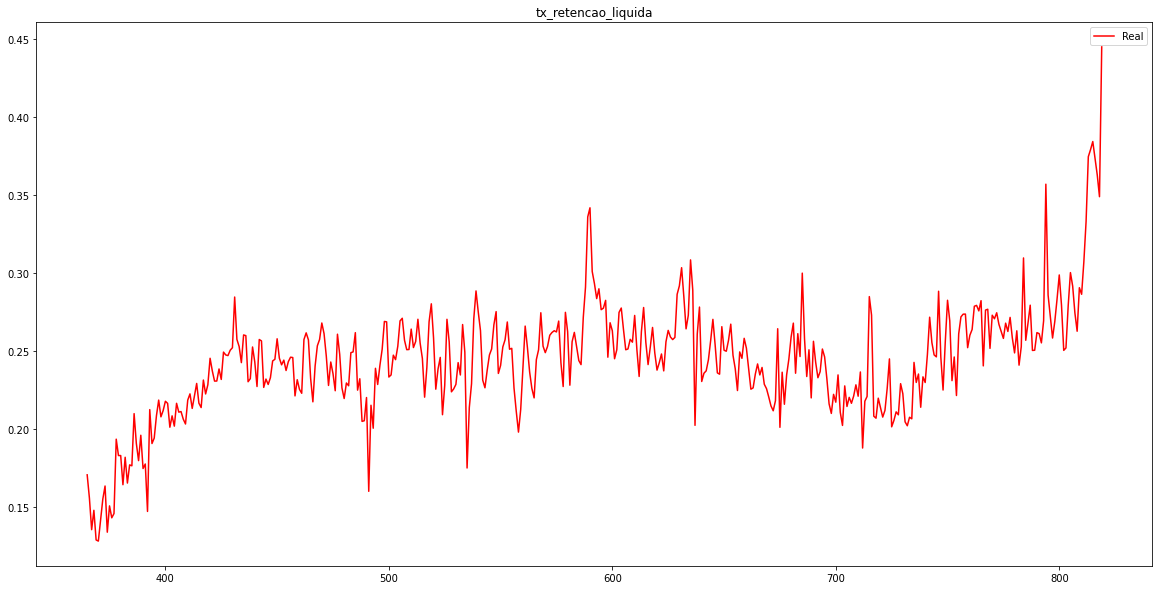

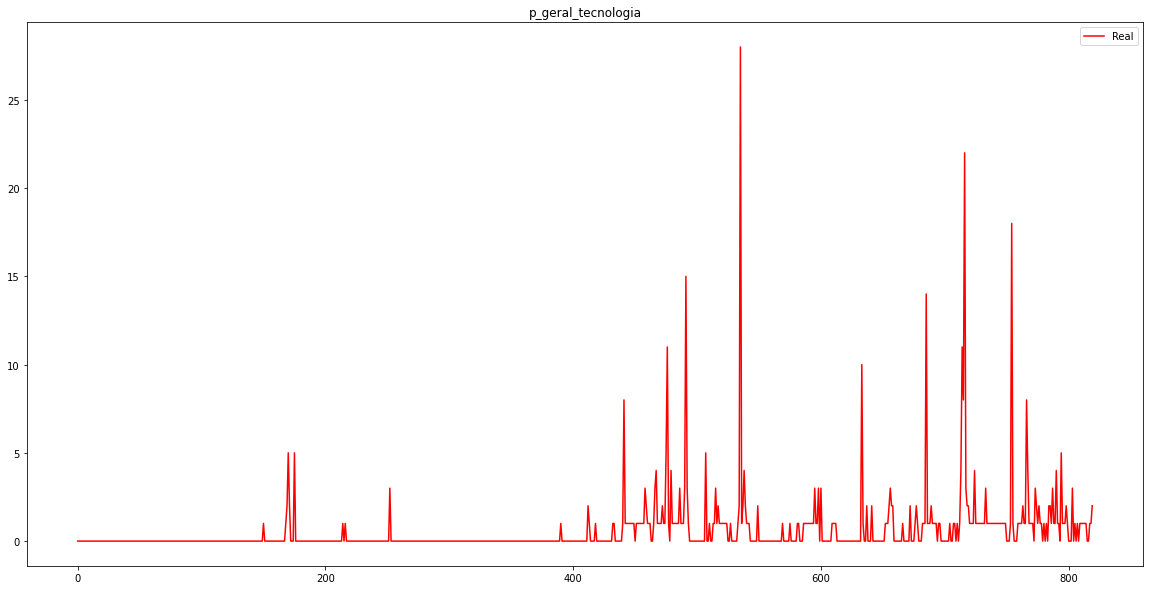

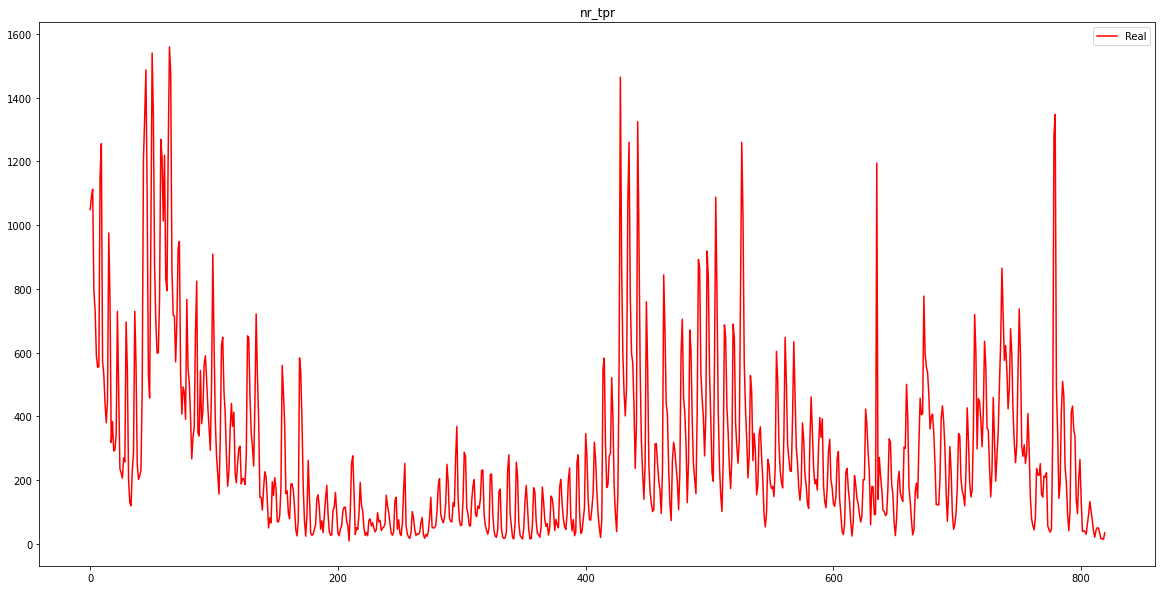

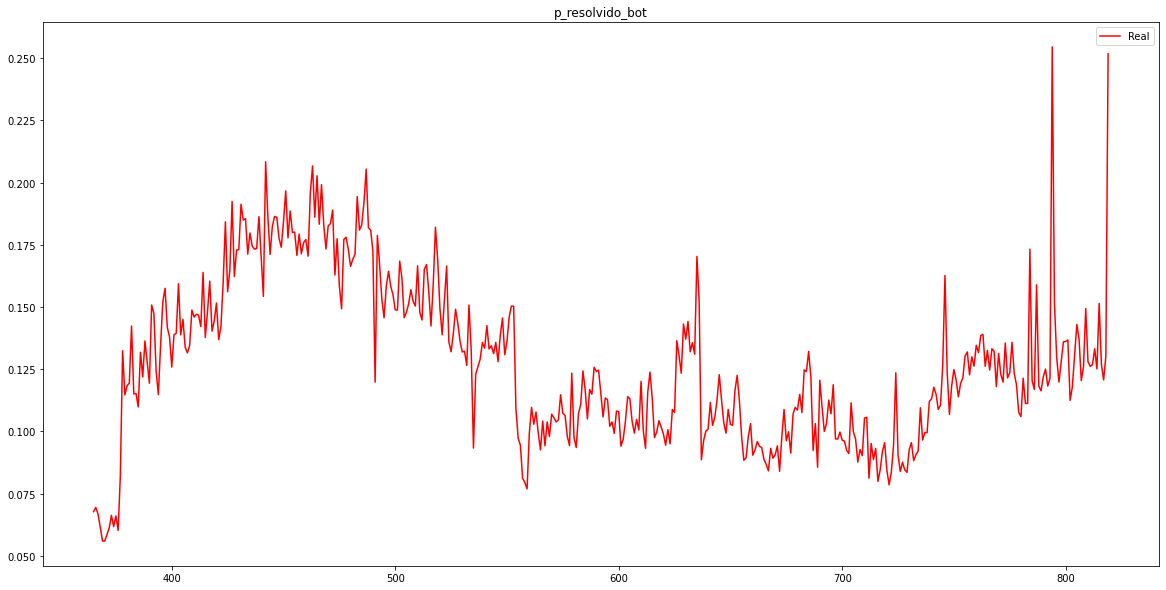

In [5]:
graficos = ['tx_retencao_liquida', 'p_geral_tecnologia', 'nr_tpr', 'p_resolvido_bot']
for i in graficos:
  plt.figure(figsize=(20,10))
  plt.plot(df[i], color = 'red', label = 'Real')
  plt.legend()
  plt.title(i)


Criar categorias Outros para assuntos



In [6]:
df['p_geral_outros'] = 100 - (df.p_geral_tecnologia + df.p_pagamento + df.p_fatura + df.p_fraude + df.p_geral_cartao +
df.p_geral_conta + df.p_geral_tecnologia + df.p_logistica + df.p_cadastro)

Tratar tecnologia

In [7]:
#substituir share 0 por 1
df['p_geral_tecnologia'] = np.where(df['p_geral_tecnologia'] == 0, 1, df['p_geral_tecnologia'])


Criando sazonais

In [8]:
df['ano'] = df['dt_chat'].map(lambda x: x.strftime('%Y'))
df['dia'] = df['dt_chat'].map(lambda x: x.strftime('%d'))
df['mes'] = df['dt_chat'].map(lambda x: x.strftime('%m'))
df['dia_semana'] = df['dt_chat'].map(lambda x: x.strftime('%A'))

## Transformação vars

In [9]:
#ajustando para percenntual de inatividade
df['p_qtd_encerrado_inatividade'] = (df['qtd_encerrado_inatividade'] / df['chats'])

In [10]:
variaveis_log = ['chats', 'tx_recontato', 'nr_tma_resolucao', 'nr_tpr', 'nr_csat', 
                 'tx_retencao_liquida', 'qtd_encerrado_inatividade', 'p_resolvido_bot', 'p_pagamento', 'p_fatura', 'p_fraude', 'p_geral_cartao',
                 'p_geral_conta', 'p_geral_tecnologia', 'p_logistica', 'p_geral_outros', 'p_cadastro', 'p_qtd_encerrado_inatividade']

for i in variaveis_log:
  df['ln_' + i] = np.log(df[i])

/home/flavia.costa/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Lags

In [11]:
for i in variaveis_log:
  df['ln_' + i + '_l1']   = np.log(df[i].shift(1))
  df['ln_' + i + '_l2']   = np.log(df[i].shift(2))

/home/flavia.costa/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/flavia.costa/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
for column in df.columns:
  df[column].fillna(0, inplace = True)

## Matriz Granger

In [13]:
maxlag=7
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [14]:
df2 = df[variaveis_log]
grangers_causation_matrix(df2, variables = df2.columns)

,chats_x,tx_recontato_x,nr_tma_resolucao_x,nr_tpr_x,nr_csat_x,tx_retencao_liquida_x,qtd_encerrado_inatividade_x,p_resolvido_bot_x,p_pagamento_x,p_fatura_x,p_fraude_x,p_geral_cartao_x,p_geral_conta_x,p_geral_tecnologia_x,p_logistica_x,p_geral_outros_x,p_cadastro_x,p_qtd_encerrado_inatividade_x
chats_y,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0008,0.0019,0.0000,0.0000,0.0000,0.0000,0.0000
tx_recontato_y,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0004,0.0000,0.0000,0.0000,0.1938,0.0000,0.0000,0.0000,0.0000
nr_tma_resolucao_y,0.0000,0.0006,1.0000,0.0074,0.0000,0.0000,0.0000,0.0000,0.0007,0.0000,0.0109,0.0999,0.2202,0.4654,0.0181,0.0000,0.0000,0.0000
nr_tpr_y,0.0000,0.0000,0.0972,1.0000,0.0000,0.0039,0.0000,0.3264,0.0000,0.0001,0.0000,0.0094,0.0783,0.0414,0.0000,0.0021,0.0000,0.0000
nr_csat_y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0001,0.0267,0.0007,0.0000,0.0000,0.0000,0.0000
tx_retencao_liquida_y,0.0000,0.0000,0.0021,0.0000,0.1403,1.0000,0.0000,0.0036,0.0007,0.1469,0.0013,0.1845,0.0001,0.0487,0.0165,0.0064,0.1338,0.0760
qtd_encerrado_inatividade_y,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0003,0.0002,0.0123,0.0009,0.0000,0.0000,0.0001,0.0000
p_resolvido_bot_y,0.2434,0.2327,0.0087,0.4655,0.0120,0.0000,0.3327,1.0000,0.0816,0.0897,0.0808,0.4185,0.0076,0.0122,0.4570,0.5508,0.4146,0.0044
p_pagamento_y,0.0000,0.0000,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0002,0.0004,0.0000,0.0696,0.0000,0.0000,0.0000,0.0000
p_fatura_y,0.0000,0.0014,0.0000,0.0625,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0659,0.0377,0.0021,0.6739,0.0000,0.0000,0.0000,0.0000


## Correlações

In [15]:
df[variaveis_log].corr()

,chats,tx_recontato,nr_tma_resolucao,nr_tpr,nr_csat,tx_retencao_liquida,qtd_encerrado_inatividade,p_resolvido_bot,p_pagamento,p_fatura,p_fraude,p_geral_cartao,p_geral_conta,p_geral_tecnologia,p_logistica,p_geral_outros,p_cadastro,p_qtd_encerrado_inatividade
chats,1.000000,0.308073,-0.558352,-0.119202,-0.626635,0.725677,0.978239,0.712277,-0.163128,-0.536888,-0.396724,0.002203,0.470378,0.238226,-0.496574,0.547845,-0.656395,0.245549
tx_recontato,0.308073,1.000000,-0.310603,0.014982,-0.416002,0.375696,0.262866,0.512745,-0.388445,-0.277481,0.056290,-0.217888,0.296051,0.176090,-0.134358,0.260559,-0.174884,0.094865
nr_tma_resolucao,-0.558352,-0.310603,1.000000,0.294951,0.466289,-0.660893,-0.592774,-0.604780,0.259778,0.444508,0.248671,-0.021780,-0.332224,-0.136702,0.292068,-0.491569,0.471741,-0.455942
nr_tpr,-0.119202,0.014982,0.294951,1.000000,-0.219481,0.032357,-0.133412,0.070130,-0.294153,0.018197,0.192942,-0.280385,0.011864,0.024757,-0.222724,0.128018,0.173953,-0.112354
nr_csat,-0.626635,-0.416002,0.466289,-0.219481,1.000000,-0.784488,-0.666353,-0.733807,0.575761,0.452519,0.132072,0.012719,-0.437753,-0.233032,0.558041,-0.672768,0.555396,-0.552735
tx_retencao_liquida,0.725677,0.375696,-0.660893,0.032357,-0.784488,1.000000,0.756619,0.936552,-0.522928,-0.671267,-0.261312,-0.012829,0.421880,0.124914,-0.521099,0.852045,-0.627331,0.469465
qtd_encerrado_inatividade,0.978239,0.262866,-0.592774,-0.133412,-0.666353,0.756619,1.000000,0.698848,-0.183571,-0.555276,-0.350523,0.075217,0.424008,0.194546,-0.497975,0.577819,-0.654899,0.411941
p_resolvido_bot,0.712277,0.512745,-0.604780,0.070130,-0.733807,0.936552,0.698848,1.000000,-0.534518,-0.634697,-0.323062,-0.135563,0.471570,0.117515,-0.482930,0.841944,-0.588534,0.300240
p_pagamento,-0.163128,-0.388445,0.259778,-0.294153,0.575761,-0.522928,-0.183571,-0.534518,1.000000,0.259614,-0.225186,0.085186,-0.392205,-0.164345,0.173053,-0.521764,0.085072,-0.344721
p_fatura,-0.536888,-0.277481,0.444508,0.018197,0.452519,-0.671267,-0.555276,-0.634697,0.259614,1.000000,0.078402,0.010408,-0.426101,-0.138575,0.233304,-0.586118,0.325903,-0.304378


## Criando as relações de negócio

In [16]:
G = nx.DiGraph()
# adicionando vertices
G.add_node('CHATS')
G.add_node('TMAT')
G.add_node('TPR')
G.add_node('CSAT')
G.add_node('RECONTATO')
G.add_node('RETENÇÃO')
G.add_edge('CHATS', 'TMAT')
G.add_edge('CHATS', 'TPR')
G.add_edge('TMAT', 'CSAT')
G.add_edge('TPR', 'CSAT')
G.add_edge('CSAT', 'RECONTATO')
G.add_edge('TPR', 'RECONTATO')
G.add_edge('TMAT', 'RECONTATO')
G.add_edge('RECONTATO', 'RETENÇÃO')
G.add_edge('RECONTATO', 'CHATS')
G.add_node('ABANDONO')
G.add_edge('ABANDONO', 'RECONTATO')
G.add_edge('TPR', 'ABANDONO')
G.add_edge('TMAT', 'ABANDONO')
G.add_edge('ABANDONO', 'RETENÇÃO')
G.add_edge('CHATS', 'ABANDONO')
G.add_edge('RECONTATO', 'CSAT')

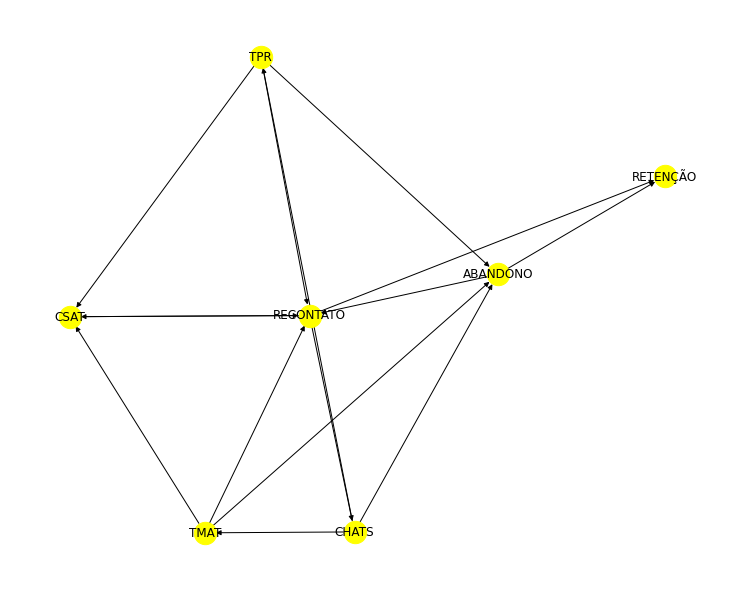

In [17]:
plt.figure(figsize=(10,8))
nx.draw(G, with_labels=True, node_size=500, node_color='yellow', font_size=12)
plt.show()

## Variáveis de interesse principais

In [18]:
vars_resultados = ['ln_chats', 'ln_tx_recontato', 'ln_nr_tma_resolucao',
       'ln_nr_tpr', 'ln_nr_csat', 'ln_tx_retencao_liquida',
       'ln_qtd_encerrado_inatividade', 'ln_p_pagamento', 'ln_p_fatura',
       'ln_p_fraude', 'ln_p_logistica', 'ln_p_geral_cartao',
       'ln_p_geral_conta', 'ln_p_geral_tecnologia', 'ln_p_cadastro', 'ln_p_geral_outros',
       'ln_p_geral_tecnologia',
       'ln_tx_recontato_l1', 'ln_tx_recontato_l2', 'ln_tx_retencao_liquida_l1',
       'ln_tx_retencao_liquida_l2', 'ln_nr_csat_l1', 'ln_nr_csat_l2',
       'ln_qtd_encerrado_inatividade_l1', 'ln_qtd_encerrado_inatividade_l2',
       'ln_nr_tma_resolucao_l1', 'ln_nr_tma_resolucao_l2',
       'ln_p_resolvido_bot', 'p_qtd_encerrado_inatividade',
       'ln_p_qtd_encerrado_inatividade']

## Funções para modelagem

In [19]:
def resultados_regressao(df, formula_text, vars_resultados, var_resposta):
  model = ols(formula = formula_text, data = df).fit()
  prediction = np.exp(model.predict(df))
  #Unificando predição total
  projecao_final = pd.DataFrame()
  projecao_final['prediction_test'] = prediction
  projecao_final['real'] = df[var_resposta]
  #métricas
  mape = np.mean(np.abs((projecao_final['real'] - projecao_final['prediction_test']) / projecao_final['real'])) * 100
  print("=================================================================")
  print('MAPE: ', mape)
  print("=================================================================")
  mae = np.median(np.abs((projecao_final['real'] - projecao_final['prediction_test']) / projecao_final['real'])) * 100
  print('MAE: ', mae)
  print("=================================================================")
  #exportando resultados para um dataframe
  results_as_html = model.summary().tables[1].as_html()
  results = pd.read_html(results_as_html, header=0, index_col=0)[0]
  results = results[results['P>|t|'] <= 0.05]
  results['Modelo'] = var_resposta
  results = results.reset_index()
  #mostrando resultados com significância - conf 95%
  print(results[results['index'].isin(vars_resultados)])
  return results



In [20]:
#Função para apendar vários modelos
def resume_resultados(nomes_modelos):
  resultados_final = pd.DataFrame()
  for i in nomes_modelos:
    resultados_final = resultados_final.append(i)
  return resultados_final

## Modelo TMA

In [21]:
formula_text = ("""
    
    ln_nr_tma_resolucao ~ 
    ln_chats +
    ln_nr_tpr +
    C(ds_holiday_or_event) +    
    ln_p_logistica +
    ln_p_pagamento + 
    ln_p_fatura +
    ln_p_geral_conta +
    ln_p_geral_cartao +
    ln_p_cadastro +
    ln_p_fraude +
    ln_p_geral_tecnologia + 
    ln_p_geral_outros +
    C(ano) + 
    C(dia) * C(dia_semana) +
    C(mes) 
    
        
    """)

mod_tma = resultados_regressao(df, formula_text, vars_resultados, 'nr_tma_resolucao')

MAPE:  16.16080950844527
MAE:  13.168792019696735
                index    coef  std err      t  P>|t|  [0.025  0.975]  \
48           ln_chats -0.1785    0.089 -1.995  0.047  -0.354  -0.003   
49          ln_nr_tpr  0.1359    0.018  7.759  0.000   0.102   0.170   
50     ln_p_logistica  0.3319    0.081  4.077  0.000   0.172   0.492   
51  ln_p_geral_cartao  0.0816    0.041  2.015  0.044   0.002   0.161   
52      ln_p_cadastro -0.1639    0.072 -2.290  0.022  -0.304  -0.023   
53        ln_p_fraude  0.1768    0.069  2.566  0.011   0.041   0.312   
54  ln_p_geral_outros  0.1625    0.076  2.139  0.033   0.013   0.312   

              Modelo  
48  nr_tma_resolucao  
49  nr_tma_resolucao  
50  nr_tma_resolucao  
51  nr_tma_resolucao  
52  nr_tma_resolucao  
53  nr_tma_resolucao  
54  nr_tma_resolucao  


Conclusão preliminar para o TMA:
- Modelo com ajuste baixo. Esse indicador parece ser altamente influenciado pelos problemas enfrentados pelo agente em cada dia
- A quantidade de chats impacta negativamente. O atendimento pode ser agilizado por conta da fila de atendimento
- TPR com impacto positivo: O tpr pode estar funcionando aqui no modelo como um proxy de dificuldades de alocação (no segundo teste não foi significativo)

Recomendado:
- Identificar problemas de negócio das principais frentes que possam impactar na dificuldade de resolução de problemas:
Fraude, Logística, Cadastro, Autorização, Instabilidade, Etc

- A logística mostra grande impacto no TMA
- A inserção dos assuntos melhorou bastante o acerto
- Nr de chats perde a significancia 

## Modelo TPR

In [22]:
#Em um primeiro teste foi identificado um oulier na previsão. Essa flag é uma tentativa de isolar o seu efeito
df['out_prev_tpr'] = np.where(df['dt_chat'] == np.datetime64('2022-03-05'), 1, 0)

In [23]:
formula_text = ("""
    ln_nr_tpr ~
    ln_chats +
    ln_p_pagamento + 
    ln_p_fatura + 
    ln_p_fraude + 
    ln_p_logistica + 
    ln_p_geral_cartao +
    ln_p_cadastro +
    ln_p_geral_tecnologia + 
    ln_p_geral_outros +
    out_prev_tpr +
    ln_p_geral_conta +
    ln_p_resolvido_bot + 
    C(ds_holiday_or_event) * C(dia_semana) +
    C(ano) + 
    C(dia) * C(dia_semana) +
    C(mes) 
        
    """)

mod_tpr = resultados_regressao(df, formula_text, vars_resultados, 'nr_tpr')

MAPE:  37.7690652039383
MAE:  27.82919030995733
                 index    coef  std err      t  P>|t|  [0.025  0.975]  Modelo
49            ln_chats  1.2960    0.242  5.359  0.000   0.821   1.771  nr_tpr
50      ln_p_pagamento -0.6484    0.213 -3.048  0.002  -1.066  -0.230  nr_tpr
51         ln_p_fatura -0.4188    0.158 -2.651  0.008  -0.729  -0.108  nr_tpr
52         ln_p_fraude  0.5717    0.172  3.326  0.001   0.234   0.909  nr_tpr
53      ln_p_logistica -1.1991    0.193 -6.208  0.000  -1.579  -0.820  nr_tpr
54   ln_p_geral_outros  0.5726    0.190  3.007  0.003   0.198   0.947  nr_tpr
56    ln_p_geral_conta -0.2378    0.072 -3.320  0.001  -0.379  -0.097  nr_tpr
57  ln_p_resolvido_bot -1.1657    0.214 -5.443  0.000  -1.586  -0.745  nr_tpr


Conclusão preliminar para o TPR:
- Modelo com ajuste insuficiente. Assim como o TMA, esse indicador parece ser altamente influenciado pelos problemas enfrentados pelo agente em cada dia
- A quantidade de chats tem relação de 1 pra 1

Recomendado:
- Identificar problemas de negócio das principais frentes que possam impactar na dificuldade de resolução de problemas:
Fraude, Logística, Cadastro, Autorização, Instabilidade, Etc

- Acerto continua muito abaixo do esperado
- Relação do nr de chats diminui para 0.64
- Mais chats de logística, fatura e pagamento geram queda no TPR

## Modelo CSAT

In [24]:
formula_text = ("""
    ln_nr_csat ~
    ln_nr_tpr +
    nr_tma_resolucao + 
    ln_tx_recontato_l1 + 
    ln_p_resolvido_bot +
    ln_p_qtd_encerrado_inatividade + 
    ln_qtd_encerrado_inatividade_l1 +
    ln_qtd_encerrado_inatividade_l2 +
    C(is_holiday) +
    C(ano) + 
    C(dia) * C(dia_semana) +
    C(mes) 
        
    """)

mod_csat = resultados_regressao(df, formula_text, vars_resultados, 'nr_csat')

MAPE:  1.3066601501723143
MAE:  1.0197392262588818
                              index    coef  std err       t  P>|t|  [0.025  \
39                        ln_nr_tpr -0.0200    0.001 -15.258    0.0  -0.023   
40               ln_tx_recontato_l1 -0.0615    0.008  -7.733    0.0  -0.077   
41  ln_qtd_encerrado_inatividade_l1 -0.0147    0.004  -3.878    0.0  -0.022   

    0.975]   Modelo  
39  -0.017  nr_csat  
40  -0.046  nr_csat  
41  -0.007  nr_csat  


Sobre o CSAT:

- Ótimo ajuste.
- Variáveis mensais com grande importância
- TMA com impacto não significativo
- TPR com impacto significativo estatisticamente, de ordem negativa, mas com baixo valor
- O recontato do dia anterior mostrou impacto negativo
- Se colocar os assuntos como preditoras elas roubam importância do TPR, indicando que existe uma relação entre essas

Obs: retirei o recontato lag 2 por falta de significância

## Modelo Recontato

In [25]:
formula_text = ("""
    ln_tx_recontato ~
    ln_nr_csat +
    ln_nr_tma_resolucao +
    ln_qtd_encerrado_inatividade +  
    ln_nr_tpr + 
    C(is_holiday) +
    C(ano) + 
    C(dia) * C(dia_semana) +
    C(mes) 
        
    """)

mod_recontato = resultados_regressao(df, formula_text, vars_resultados, 'tx_recontato')

MAPE:  6.513525421715108
MAE:  4.9696615923421
                   index    coef  std err      t  P>|t|  [0.025  0.975]  \
101           ln_nr_csat -1.7624    0.194 -9.084    0.0  -2.143  -1.381   
102  ln_nr_tma_resolucao -0.0600    0.017 -3.626    0.0  -0.093  -0.028   
103            ln_nr_tpr -0.0675    0.007 -9.524    0.0  -0.081  -0.054   

           Modelo  
101  tx_recontato  
102  tx_recontato  
103  tx_recontato  


Sobre o Recontato:

- Bom ajuste
- O CSAT tem impacto inverso (aumenta o CSAT, cai o recontato). Relação um pouco acima de 1:1 (-1.18)

Obs: Retirei os lags de tma por falta de significância assim como o abandono

## Modelo de Chats

In [26]:
formula_text = ("""
    ln_chats ~
    ln_tx_recontato_l1 +
    C(ds_holiday_or_event) +
    C(ano) + 
    C(dia) * C(dia_semana) +
    C(mes) 
        
    """)

mod_chats = resultados_regressao(df, formula_text, vars_resultados, 'chats')

MAPE:  9.768217086421577
MAE:  7.388097764659437
                  index    coef  std err      t  P>|t|  [0.025  0.975] Modelo
105  ln_tx_recontato_l1  0.3143    0.053  5.983    0.0   0.211   0.417  chats


Sobre o nr de chats
- Ajuste bom
- A unica variável de recontato que teve significancia foi a de Lag1
- Recontato com relação direta (qdo aumenta, aumenta os chats) na ordem de 0.2 aprox.

## Model de retenção

In [27]:
formula_text = ("""
    ln_tx_retencao_liquida ~
    ln_p_resolvido_bot +
    ln_qtd_encerrado_inatividade +
    ln_tx_recontato +
    ln_tx_recontato_l1 +
    ln_qtd_encerrado_inatividade_l1 +
    C(ds_holiday_or_event) +
    C(ano) + 
    C(dia) * C(dia_semana) +
    C(mes) 
        
    """)

mod_retencao = resultados_regressao(df, formula_text, vars_resultados, 'tx_retencao_liquida')

MAPE:  inf
MAE:  9.492957235056956
                              index    coef  std err       t  P>|t|  [0.025  \
61               ln_p_resolvido_bot  0.3085    0.021  14.770    0.0   0.267   
62     ln_qtd_encerrado_inatividade  0.1693    0.019   8.982    0.0   0.132   
63                  ln_tx_recontato -0.1233    0.032  -3.912    0.0  -0.185   
64               ln_tx_recontato_l1 -0.1544    0.032  -4.752    0.0  -0.218   
65  ln_qtd_encerrado_inatividade_l1 -0.0423    0.011  -3.906    0.0  -0.064   

    0.975]               Modelo  
61   0.350  tx_retencao_liquida  
62   0.206  tx_retencao_liquida  
63  -0.061  tx_retencao_liquida  
64  -0.091  tx_retencao_liquida  
65  -0.021  tx_retencao_liquida  


Sobre a retenção:
- Abandono tem relação direta de patamar 0.5
- Recontato relação inversa de patamar 0.16
- Os lags de ordem 1 de abandono e recontato tem relação significativas
- No caso do recontato o lag 1 teve mais importancia que a var calculada no mesmo dia

Quando inseridos os lags:
- Abandono tem relação direta de patamar 0.4
- Recontato relação inversa de patamar 0.18
- Mesmos comentários do modelo anterior sobre recontato
- Percentual de resolução pelo Bot aumenta muito o acerto

## Modelo de Abandono
abandono ~ chats + tma + tpr

In [28]:
formula_text = ("""
    ln_p_qtd_encerrado_inatividade ~
    ln_nr_tma_resolucao +
    ln_p_resolvido_bot + 
    ln_nr_tpr +
    C(ds_holiday_or_event) +
    C(ano) + 
    C(dia) * C(dia_semana) +
    C(mes) 
        
    """)

mod_abandono = resultados_regressao(df, formula_text, vars_resultados, 'p_qtd_encerrado_inatividade')

MAPE:  4.546981632039818
MAE:  3.5928919099845453
                  index    coef  std err      t  P>|t|  [0.025  0.975]  \
99   ln_p_resolvido_bot -0.1272    0.022 -5.754  0.000  -0.171  -0.084   
100           ln_nr_tpr  0.0094    0.005  2.034  0.042   0.000   0.019   

                          Modelo  
99   p_qtd_encerrado_inatividade  
100  p_qtd_encerrado_inatividade  


Sobre o abandono:
- Ajuste excelente
- TMA com relação fraca e inversa
- TPR com relação fraca e direta
- Tanto o abandono como a Retenção podem ser melhor explicados se incluirmos a resolutividade do bot (testar)

- Após inserida a resolução do bot, ela rouba a importancia do TMA no abandono
- TPR continua significativo mas com baixo impacto

# Análise de todos os coeficientes (sem sazonais)

In [29]:
modelos = [mod_tma, mod_tpr, mod_chats, mod_csat, mod_recontato, mod_abandono, mod_retencao]

resultados_final = resume_resultados(modelos)

/tmp/ipykernel_342059/4169003710.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_final = resultados_final.append(i)
/tmp/ipykernel_342059/4169003710.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_final = resultados_final.append(i)
/tmp/ipykernel_342059/4169003710.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_final = resultados_final.append(i)
/tmp/ipykernel_342059/4169003710.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resultados_final = resultados_final.append(i)
/tmp/ipykernel_342059/4169003710.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pan

nr_tma_resolucao


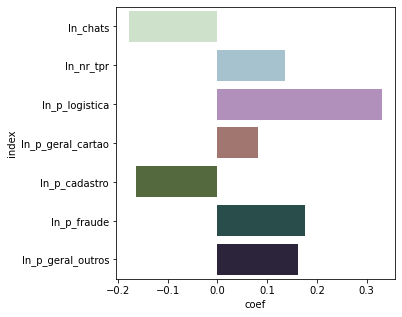

nr_tpr


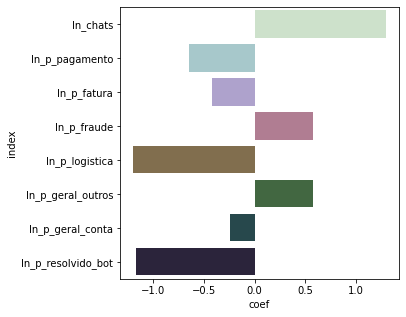

chats


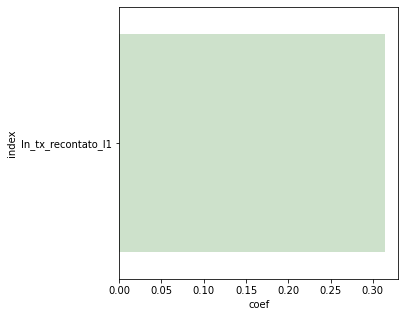

nr_csat


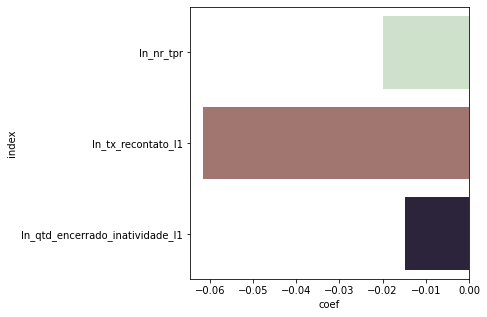

tx_recontato


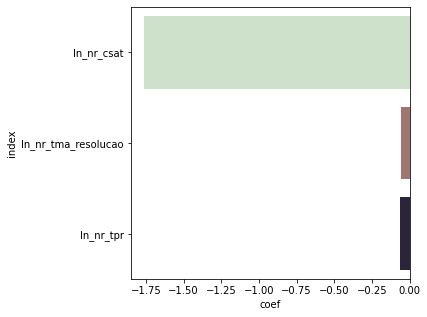

p_qtd_encerrado_inatividade


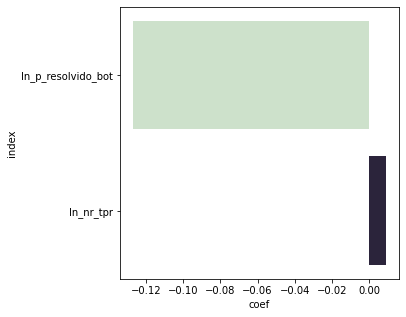

tx_retencao_liquida


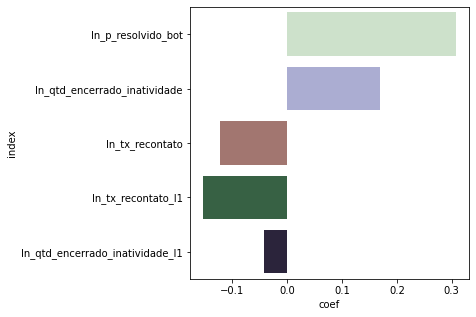

In [30]:
modelos = resultados_final['Modelo'].unique()

for i in modelos:
    df2 = resultados_final[resultados_final['Modelo'] == i]
    df2 = df2[df2['index'].isin(vars_resultados)]
    
    print("===========================================")
    print(i)
    plt.figure(figsize=(5,5))
    sns.barplot(data = df2, x = 'coef', y = 'index', palette="ch:s=1,rot=-2")
    plt.show()

##  Novas relações negócio

In [31]:
resultados_final['target'] = 'ln_' + resultados_final['Modelo']

In [32]:
resultados_final2 = resultados_final[resultados_final['P>|t|'] <= 0.05]
resultados_final2 = resultados_final2[resultados_final2['index'].isin(vars_resultados)]

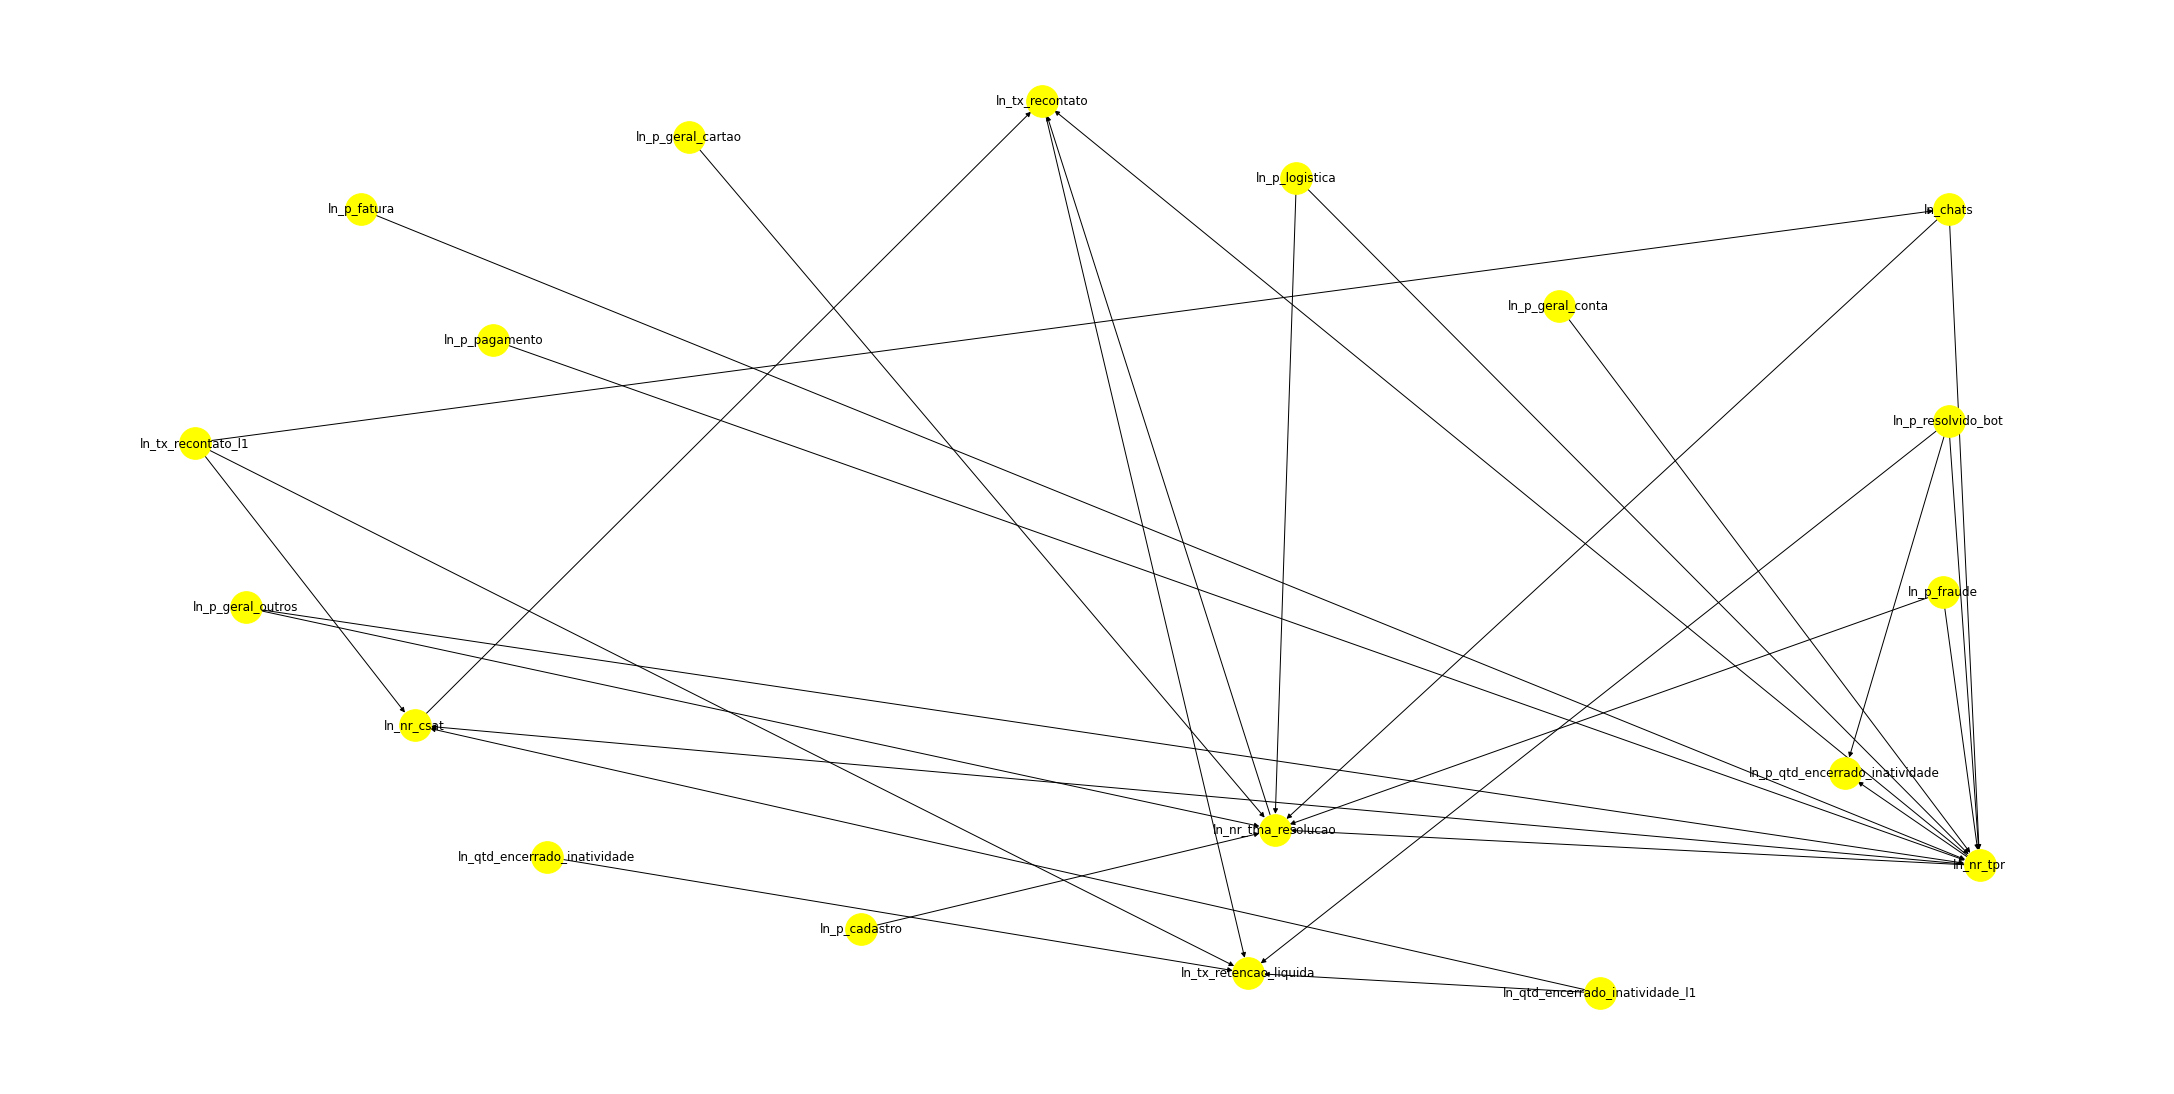

In [33]:
Graph = nx.from_pandas_edgelist(resultados_final2,source='index',target='target', edge_attr=None, create_using=nx.DiGraph())
pos = nx.spring_layout(Graph, k=1000, iterations=20)
plt.figure(figsize = (30,15))
nx.draw(Graph, with_labels=True, node_size=1000, node_color='yellow', font_size=12, pos = pos)
plt.show()

- Notas:
- O abandono é somente uma consequência do TPR, onde o mais danoso é a queda do CSAT
- A resolução do Bot 

## Modelo de logistica por outros assuntos

In [34]:
#primmeiro preciso saber a relação entre logistica e outros assuntos

formula_text = ("""
    
    ln_p_logistica ~
    ln_p_fatura +
    ln_p_pagamento + 
    ln_p_geral_conta + 
    ln_p_geral_cartao +
    ln_p_fraude +
    ln_p_geral_tecnologia +
    C(mes) + 
    C(dia_semana)
        
    """)

mod_logistica = resultados_regressao(df, formula_text, vars_resultados, 'p_logistica')

MAPE:  16.7589352777829
MAE:  13.170881163000702
                    index    coef  std err      t  P>|t|  [0.025  0.975]  \
14            ln_p_fatura  0.1842    0.030  6.212  0.000   0.126   0.242   
15       ln_p_geral_conta -0.0468    0.018 -2.546  0.011  -0.083  -0.011   
16  ln_p_geral_tecnologia -0.1445    0.021 -7.003  0.000  -0.185  -0.104   

         Modelo  
14  p_logistica  
15  p_logistica  
16  p_logistica  


## Modelo de chats futuro

In [35]:
df['ln_chats_futuro'] = np.log(df['chats'].shift(-1))
df['chats_futuro'] = df['chats'].shift(-1)

In [36]:
formula_text = ("""
    
    ln_chats_futuro ~
    ln_chats +
    ln_tx_recontato +
    C(mes) + 
    C(dia_semana)
        
    """)

mod_chats_futuro = resultados_regressao(df, formula_text, vars_resultados, 'chats_futuro')

MAPE:  12.420017210920356
MAE:  nan
             index    coef  std err       t  P>|t|  [0.025  0.975]  \
7         ln_chats  0.8461    0.014  60.422    0.0   0.819   0.874   
8  ln_tx_recontato  0.5608    0.050  11.268    0.0   0.463   0.658   

         Modelo  
7  chats_futuro  
8  chats_futuro  


## Simulação por cenários

In [37]:
print(resultados_final['Modelo'].unique())

['nr_tma_resolucao' 'nr_tpr' 'chats' 'nr_csat' 'tx_recontato'
 'p_qtd_encerrado_inatividade' 'tx_retencao_liquida']


In [38]:
medias = df[['p_logistica','p_fatura','p_pagamento', 'p_geral_conta', 'p_geral_cartao',
    'p_fraude', 'p_geral_tecnologia' , 'p_geral_outros']].mean()
medias

p_logistica           10.204878
p_fatura              10.764634
p_pagamento           20.954878
p_geral_conta          4.163415
p_geral_cartao         2.106098
p_fraude              12.757317
p_geral_tecnologia     1.295122
p_geral_outros        31.210976
dtype: float64

In [39]:
percentuais_assuntos = ['p_logistica','p_fatura','p_pagamento', 'p_geral_conta', 'p_geral_cartao',
    'p_fraude', 'p_geral_tecnologia' , 'p_geral_outros']

for i in percentuais_assuntos:
    globals()['m_%s' % i] = df[i].mean()

In [40]:
mod_tma

,index,coef,std err,t,P>|t|,[0.025,0.975],Modelo
0,Intercept,5.7825,1.243,4.651,0.000,3.340,8.225,nr_tma_resolucao
1,C(ds_holiday_or_event)[T.Dia das Mães],-0.4423,0.123,-3.601,0.000,-0.684,-0.201,nr_tma_resolucao
2,C(ds_holiday_or_event)[T.Independência do Brasil],-0.4075,0.206,-1.977,0.049,-0.812,-0.003,nr_tma_resolucao
3,C(ds_holiday_or_event)[T.Proclamação da Repúbl...,-0.4634,0.174,-2.660,0.008,-0.806,-0.121,nr_tma_resolucao
4,C(ds_holiday_or_event)[T.Tiradentes],-0.4919,0.171,-2.876,0.004,-0.828,-0.156,nr_tma_resolucao
5,C(ano)[T.2022],-0.5147,0.079,-6.533,0.000,-0.669,-0.360,nr_tma_resolucao
6,C(ano)[T.2023],-1.2135,0.104,-11.635,0.000,-1.418,-1.009,nr_tma_resolucao
7,C(dia)[T.05],0.3791,0.188,2.019,0.044,0.010,0.748,nr_tma_resolucao
8,C(dia)[T.06],0.5201,0.207,2.512,0.012,0.113,0.927,nr_tma_resolucao
9,C(dia)[T.10],0.4326,0.180,2.398,0.017,0.078,0.787,nr_tma_resolucao


In [41]:
def sim(n):
    
    percentuais_assuntos = ['p_logistica','p_fatura','p_pagamento', 'p_geral_conta', 'p_geral_cartao',
    'p_fraude', 'p_geral_tecnologia' , 'p_geral_outros']

    for i in percentuais_assuntos:
        globals()['m_%s' % i] = df[i].mean()
    
    
    result_simulacao = pd.DataFrame([], columns=['delta_nr_chats', 'delta_p_cartao', 'delta_resolucao_bot', 'delta_p_fatura', 
                                                 'delta_p_logistica', 'delta_csat','delta_tpr','delta_tmat',
                                                 'delta_p_tecnologia', 'delta_p_outros', 'delta_p_fraude',
                                                 'delta_recontato','delta_abandono', 'delta_retencao'])
    #result_simulacao = []
    lim_sup = 0.5
    lim_inf = -0.2
    
    
    for n in range(n):
        

        delta_nr_chats = 0
               
        delta_p_fatura = random.uniform(lim_inf, lim_sup)
        delta_p_pagamento = random.uniform(lim_inf, lim_sup)
        delta_p_conta = random.uniform(lim_inf, lim_sup)
        delta_p_cartao = random.uniform(lim_inf, lim_sup)
        delta_p_tecnologia = random.uniform(lim_inf, lim_sup)
        delta_p_fraude = random.uniform(lim_inf, lim_sup)
        delta_resolucao_bot = random.uniform(lim_inf, lim_sup)

        delta_p_logistica = delta_p_fatura * mod_logistica.loc[mod_logistica['index'] == 'ln_p_fatura', 'coef'].values[0] + \
            delta_p_tecnologia  * mod_logistica.loc[mod_logistica['index'] == 'ln_p_geral_tecnologia', 'coef'].values[0] 
        #+ \  delta_p_fraude  * mod_logistica.loc[mod_logistica['index'] == 'ln_p_fraude', 'coef'].values[0]
        
        
        #mudar para dependente e outros
        
        s_p_outros_a = m_p_geral_outros
        s_p_outros_d = 100 - (m_p_logistica * (1 + delta_p_logistica) + 
                              m_p_fatura * (1 + delta_p_fatura) +
                              m_p_pagamento * (1 + delta_p_pagamento) +
                              m_p_geral_conta * (1 + delta_p_conta) +
                              m_p_geral_cartao * (1 + delta_p_cartao) +
                              m_p_geral_tecnologia * (1 + delta_p_tecnologia) +
                              m_p_fraude * (1 + delta_p_fraude) )
        
        delta_p_outros = (s_p_outros_d / s_p_outros_a) - 1
                
        delta_tpr = delta_nr_chats * mod_tpr.loc[mod_tpr['index'] == 'ln_chats', 'coef'].values[0] + \
            delta_p_pagamento * mod_tpr.loc[mod_tpr['index'] == 'ln_p_pagamento', 'coef'].values[0] + \
            delta_p_fatura * mod_tpr.loc[mod_tpr['index'] == 'ln_p_fatura', 'coef'].values[0] + \
            delta_p_logistica * mod_tpr.loc[mod_tpr['index'] == 'ln_p_logistica', 'coef'].values[0] + \
            delta_p_conta * mod_tpr.loc[mod_tpr['index'] == 'ln_p_geral_conta', 'coef'].values[0] + \
            delta_resolucao_bot * mod_tpr.loc[mod_tpr['index'] == 'ln_p_resolvido_bot', 'coef'].values[0] + \
            delta_p_outros * mod_tpr.loc[mod_tpr['index'] == 'ln_p_geral_outros', 'coef'].values[0]
        
        delta_tmat = delta_tpr * mod_tma.loc[mod_tma['index'] == 'ln_nr_tpr', 'coef'].values[0] + \
        delta_p_logistica * mod_tma.loc[mod_tma['index'] == 'ln_p_logistica', 'coef'].values[0] + \
        delta_p_cartao *  mod_tma.loc[mod_tma['index'] == 'ln_p_geral_cartao', 'coef'].values[0] + \
        delta_p_fraude *  mod_tma.loc[mod_tma['index'] == 'ln_p_fraude', 'coef'].values[0] + \
         delta_p_outros *  mod_tma.loc[mod_tma['index'] == 'ln_p_geral_outros', 'coef'].values[0]    

        delta_abandono = delta_resolucao_bot * mod_abandono.loc[mod_abandono['index'] == 'ln_p_resolvido_bot', 'coef'].values[0]   
        
        delta_csat = delta_tpr * mod_csat.loc[mod_csat['index'] == 'ln_nr_tpr', 'coef'].values[0] + \
        delta_abandono  * mod_csat.loc[mod_csat['index'] == 'ln_qtd_encerrado_inatividade_l1', 'coef'].values[0]  
        
        delta_recontato = delta_csat * mod_recontato.loc[mod_recontato['index'] == 'ln_nr_csat', 'coef'].values[0] + \
        delta_tmat * mod_recontato.loc[mod_recontato['index'] == 'ln_nr_tma_resolucao', 'coef'].values[0] + \
        delta_tpr * mod_recontato.loc[mod_recontato['index'] == 'ln_nr_tpr', 'coef'].values[0]
        
        #delta retencao
        '''
        ln_p_resolvido_bot
        ln_qtd_encerrado_inatividade
        ln_tx_recontato
        
        '''
        
        delta_retencao = delta_resolucao_bot * mod_retencao.loc[mod_retencao['index'] == 'ln_p_resolvido_bot', 'coef'].values[0] + \
        delta_abandono * mod_retencao.loc[mod_retencao['index'] == 'ln_qtd_encerrado_inatividade', 'coef'].values[0] + \
        delta_recontato * mod_retencao.loc[mod_retencao['index'] == 'ln_tx_recontato', 'coef'].values[0]
        
        #delta chats futuro
        '''
        ln_chats
        ln_tx_recontato
                
        '''
        delta_chats_futuro = delta_recontato * mod_chats_futuro.loc[mod_chats_futuro['index'] == 'ln_tx_recontato', 'coef'].values[0]      
                
        #coletando todos os deltas
        result_temp = pd.DataFrame({'delta_nr_chats': delta_chats_futuro, #vou analisar o impacto no futuro para evitar loop
                                    'delta_p_cartao': delta_p_cartao, 
                                    'delta_resolucao_bot': delta_resolucao_bot, 'delta_p_fatura': delta_p_fatura, 
                                    'delta_p_logistica': delta_p_logistica, 
                                    'delta_csat': delta_csat, 'delta_tpr': delta_tpr,
                                    'delta_tmat': delta_tmat, 
                                    'delta_p_tecnologia': delta_p_tecnologia, 
                                    'delta_p_outros': delta_p_outros, 
                                    'delta_p_fraude': delta_p_fraude,
                                    'delta_recontato': delta_recontato,
                                    'delta_abandono': delta_abandono,
                                    'delta_retencao': delta_retencao}, index=[0])
        
        result_simulacao = result_simulacao.append(result_temp)

    return result_simulacao

In [42]:
df_simulacao = sim(1000).reset_index()

/tmp/ipykernel_342059/1129360878.py:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_simulacao = result_simulacao.append(result_temp)
/tmp/ipykernel_342059/1129360878.py:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_simulacao = result_simulacao.append(result_temp)
/tmp/ipykernel_342059/1129360878.py:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_simulacao = result_simulacao.append(result_temp)
/tmp/ipykernel_342059/1129360878.py:107: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_simulacao = result_simulacao.append(result_temp)
/tmp/ipykernel_342059/1129360878.py:107: FutureWarning: The frame.append

In [43]:
df_simulacao.head()

,index,delta_nr_chats,delta_p_cartao,delta_resolucao_bot,delta_p_fatura,delta_p_logistica,delta_csat,delta_tpr,delta_tmat,delta_p_tecnologia,delta_p_outros,delta_p_fraude,delta_recontato,delta_abandono,delta_retencao
0,0,0.018372,0.199799,0.428991,-0.109470,-0.005928,0.018158,-0.867816,-0.103100,-0.098520,-0.148115,0.138966,0.032761,-0.054568,0.119066
1,0,0.011070,-0.166827,0.003055,0.096478,-0.003176,0.010407,-0.520084,-0.049602,0.144962,-0.283308,0.462567,0.019740,-0.000389,-0.001557
2,0,0.013015,-0.138433,0.379889,0.198208,-0.009851,0.013726,-0.650773,-0.057846,0.320836,-0.055436,0.306380,0.023208,-0.048322,0.106153
3,0,-0.002131,-0.054552,0.090994,-0.139119,-0.077807,-0.000038,0.010424,0.052729,0.361115,0.070126,0.397016,-0.003800,-0.011574,0.026581
4,0,0.013940,0.077073,-0.195315,0.453368,0.012785,0.010028,-0.519660,-0.124238,0.489453,-0.295464,-0.091266,0.024858,0.024844,-0.059114


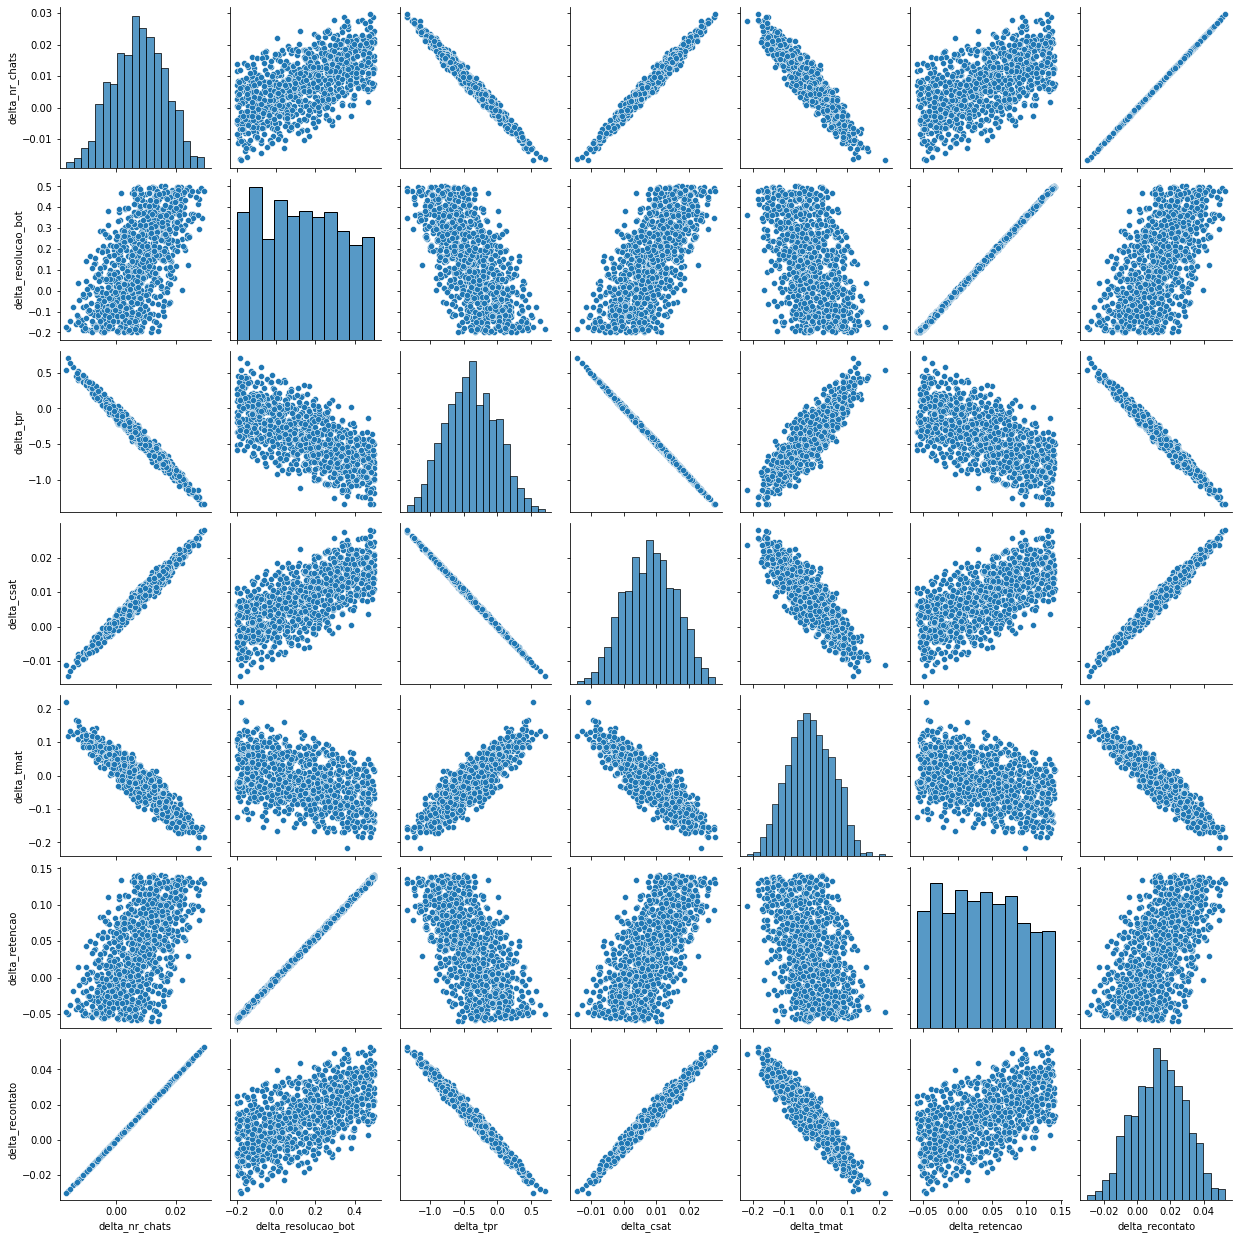

In [44]:
sns.pairplot(df_simulacao[['delta_nr_chats', 'delta_resolucao_bot', 'delta_tpr', 'delta_csat', 'delta_tmat', 'delta_retencao', 'delta_recontato']])
plt.show()

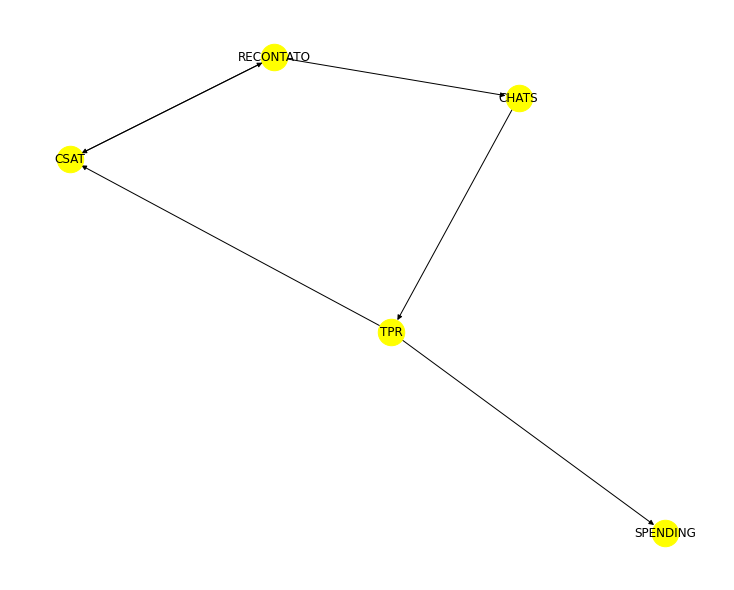

In [5]:
G = nx.DiGraph()
# adicionando vertices
G.add_node('CHATS')
#G.add_node('TMAR')
G.add_node('TPR')
G.add_node('CSAT')
G.add_node('RECONTATO')
G.add_node('SPENDING')
G.add_edge('CHATS', 'TPR')
G.add_edge('TPR', 'CSAT')
G.add_edge('CSAT', 'RECONTATO')
G.add_edge('RECONTATO', 'CHATS')
G.add_edge('RECONTATO', 'CSAT')
G.add_edge('TPR', 'SPENDING')

plt.figure(figsize=(10,8))
nx.draw(G, with_labels=True, node_size=700, node_color='yellow', font_size=12)
plt.show()